In [1]:
# If you want to run this on Google Colab, just uncomment the following lines. Please note,
# that you will need to locate your folder directly in the root directory of your Google Drive (/content/drive/My Drive/).
# Because otherwise, it won't work out of the box and you would need to adjust the path in here.
#
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#
#import os
#os.chdir("/content/drive/My Drive/CSMP-Project")

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn

import tensorflow as tf

from tensorflow import keras
from keras import layers

2023-03-05 13:58:00.825881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 13:58:01.810509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marc/Studium/WS22-23/Database Systems/dbsys22/build/debug/mutable/src/Mutable/lib:/usr/local/boost_1_80_0/stage/lib
2023-03-05 13:58:01.810563: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-05 13:58:04.332741: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64]

In [2]:
data_file = '../../../data/normMar1st.csv'

dataset = pd.read_csv(data_file, sep=';')

dataset

,normRSMH,muT,normGamma,normPulloff
0,0.112520,0.292184,0.147337,0.009895
1,0.149189,0.845373,0.099375,0.000039
2,0.060246,0.016704,0.001107,0.000133
3,0.148948,0.163739,0.081084,0.022324
4,0.072831,0.104554,0.023706,0.000205
...,...,...,...,...
244,0.085864,0.547888,0.053388,0.001356
245,0.050813,0.491781,0.139395,0.000047
246,0.072870,0.245347,0.221772,0.019321
247,0.054499,0.019218,0.011996,0.010177


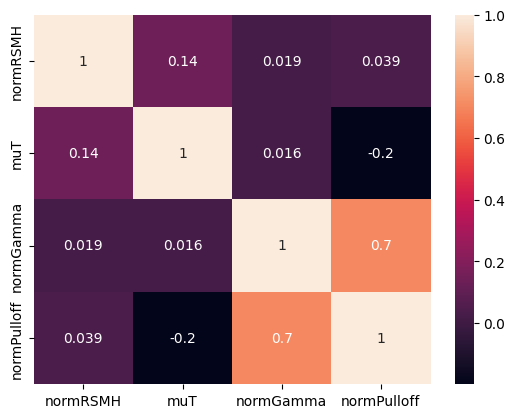

In [4]:
dataplot = sns.heatmap(dataset.corr(), cmap="rocket", annot=True)

plt.show()

In [5]:
dataset.describe()

,normRSMH,muT,normGamma,normPulloff
count,249.000000,249.000000,249.000000,249.000000
mean,0.107223,0.748952,0.159375,0.018396
std,0.055202,0.819408,0.233487,0.050092
min,0.031083,0.016704,0.000219,0.000003
25%,0.070385,0.232168,0.024677,0.000210
50%,0.089300,0.489011,0.067170,0.000638
75%,0.148825,0.917315,0.178832,0.002929
max,0.227925,5.660040,1.289770,0.357983


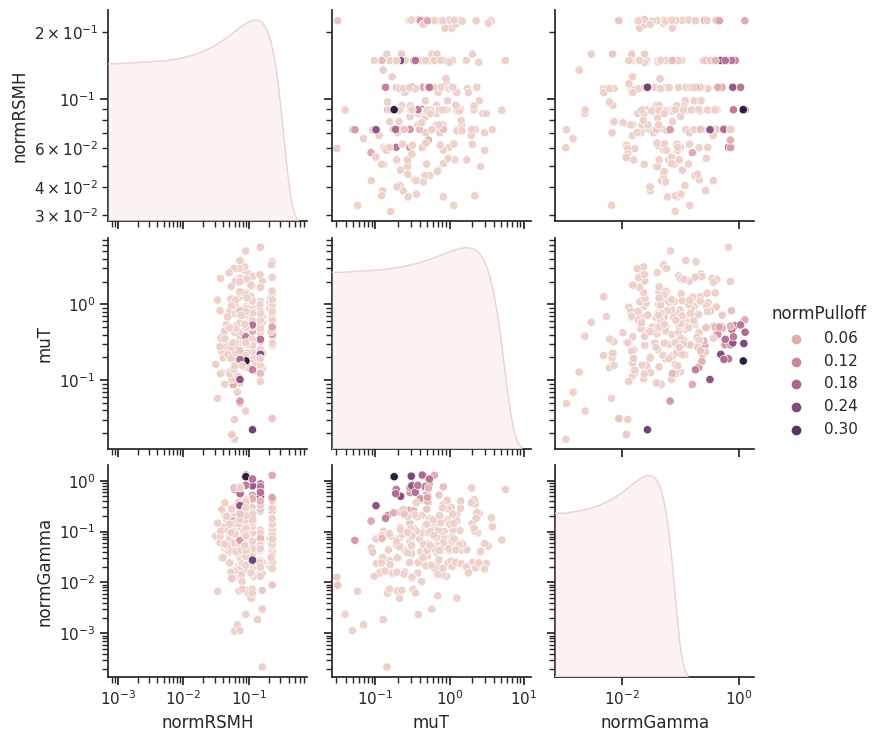

In [6]:
sns.set_theme(style="ticks")
pl = sns.pairplot(dataset, hue='normPulloff')

for ax in pl.axes.flat:
    ax.set(xscale='log')
    ax.set(yscale='log')

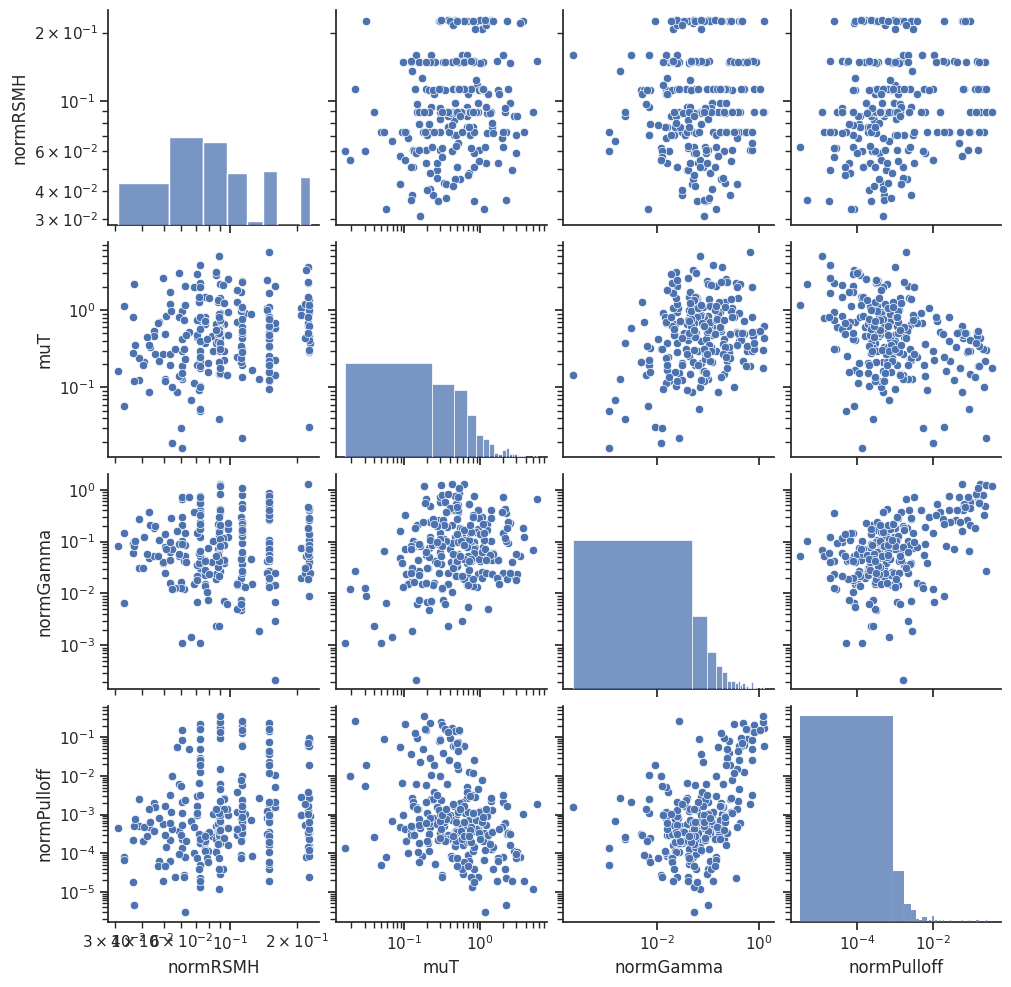

In [7]:
sns.set_theme(style="ticks")
pl = sns.pairplot(dataset)

for ax in pl.axes.flat:
    ax.set(xscale='log')
    ax.set(yscale='log')

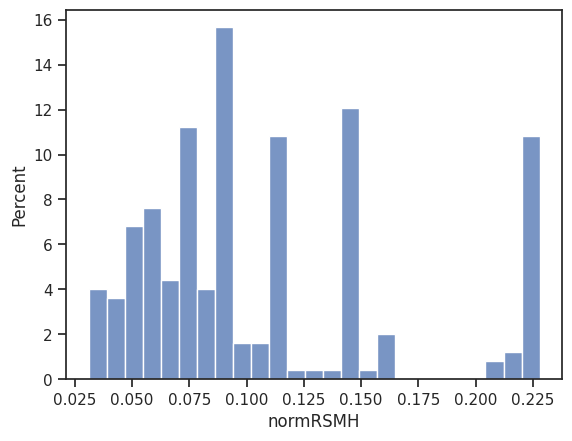

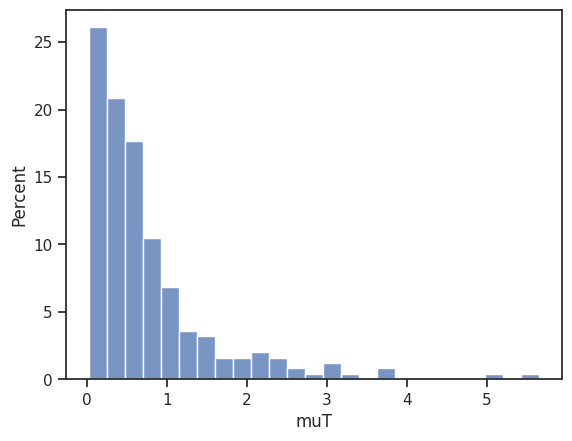

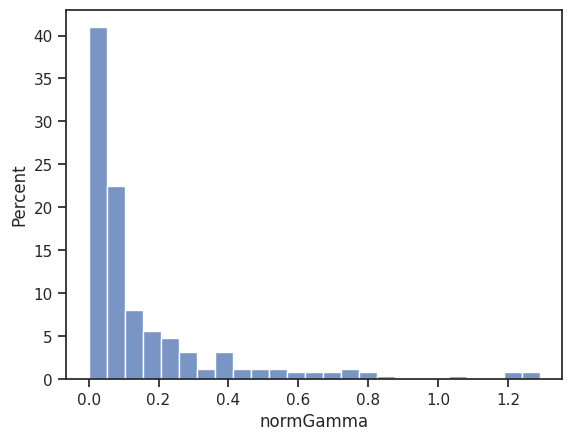

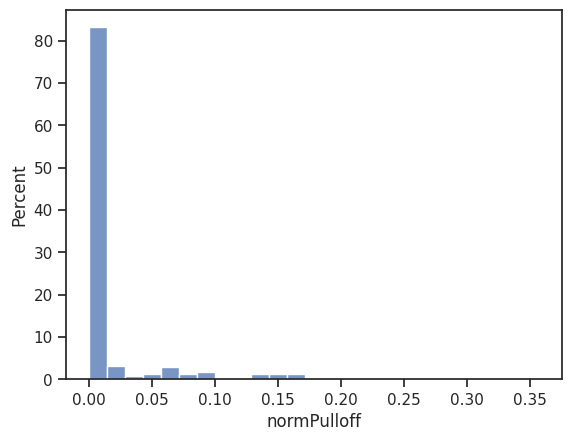

In [8]:
for col in dataset.columns:
    sns.histplot(data=dataset, x=col, stat='percent', bins=25)
    plt.show()

In [39]:
num_samples = len(dataset) - 20

train_dataset = dataset.take(range(0,num_samples))
test_dataset = dataset.drop(train_dataset.index)

test_dataset.sort_values('normGamma', inplace=True)

len(train_dataset)

229

In [40]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = list(train_features.pop('normPulloff'))
test_labels = list(test_features.pop('normPulloff'))

In [41]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

rng = np.random.RandomState()

ada_regr = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=12), n_estimators=300, learning_rate=.2, loss='square', random_state=rng
)

ada_regr.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = ada_regr.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0000241329
Root Mean squared error: 0.0049125267
Mean absolute error: 0.0030544435
Coefficient of determination: 0.98119


[]

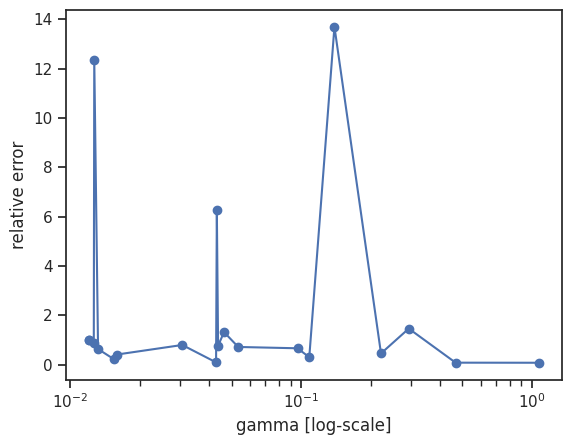

In [42]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - preds[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['normGamma'], chi, marker='o', label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

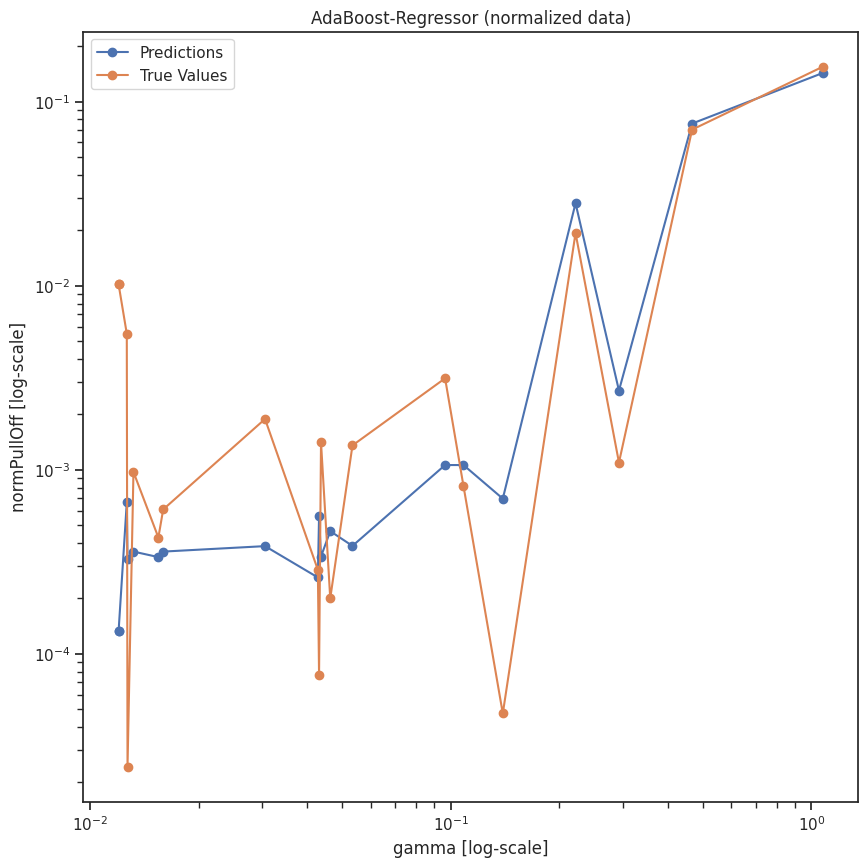

In [43]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["normGamma"], preds, ls='-', marker='o', label='Predictions')
plt.plot(test_features["normGamma"], test_labels, ls='-', marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("AdaBoost-Regressor (normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [45]:
from sklearn.ensemble import RandomForestRegressor

randForestReg = RandomForestRegressor(n_estimators=500, criterion="squared_error")
randForestReg.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = randForestReg.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0003676177
Root Mean squared error: 0.0191733580
Mean absolute error: 0.0096892968
Coefficient of determination: 0.71348


[]

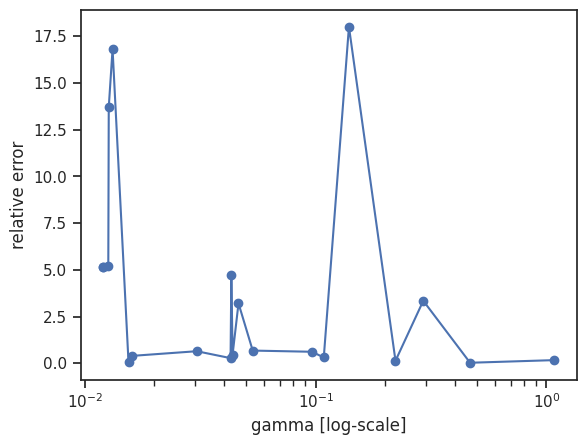

In [46]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - preds[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['normGamma'], chi, marker='o', label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

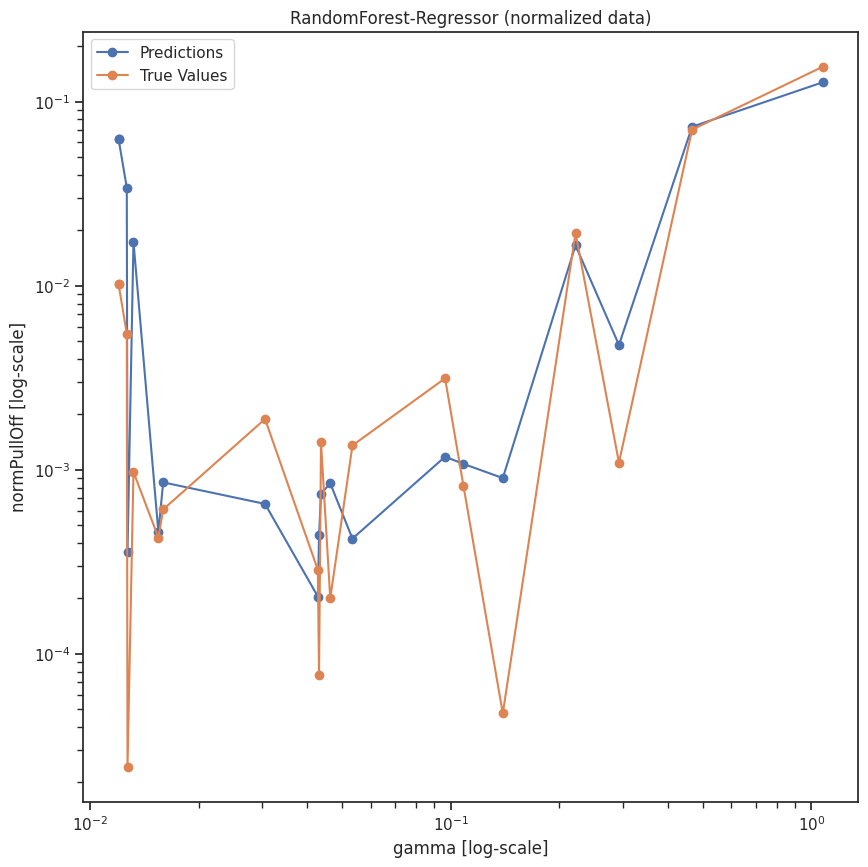

In [47]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["normGamma"], preds, ls='-', marker='o', label='Predictions')
plt.plot(test_features["normGamma"], test_labels, ls='-', marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("RandomForest-Regressor (normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

grb = GradientBoostingRegressor(
    loss='huber',
    learning_rate=0.1,
    subsample=.9,
    n_estimators=200,
    max_depth=3,
    criterion='friedman_mse',
    alpha=0.8,
    warm_start=True,
)

grb.fit(train_dataset[['muT', 'normGamma']], train_dataset['normPulloff'])

preds = grb.predict(test_dataset[['muT', 'normGamma']])

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0001818984
Root Mean squared error: 0.0134869727
Mean absolute error: 0.0074813324
Coefficient of determination: 0.85823


[]

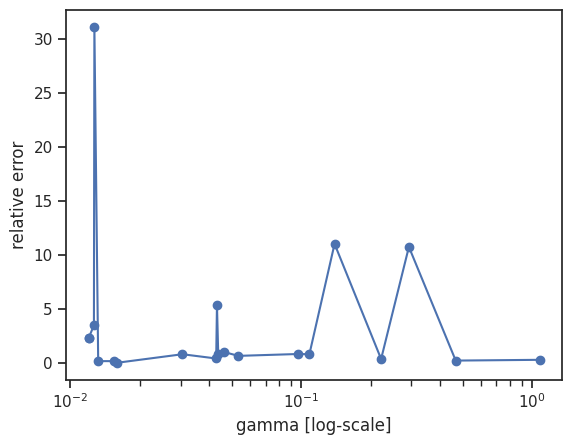

In [61]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - preds[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['normGamma'], chi, marker='o', label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

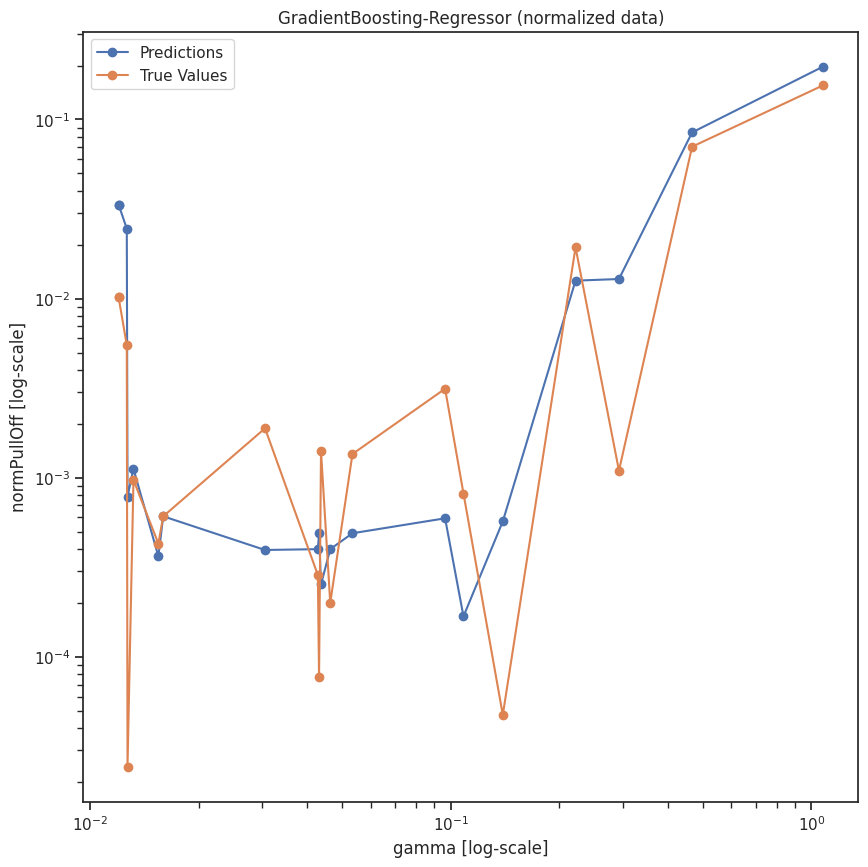

In [62]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["normGamma"], preds, ls='-', marker='o', label='Predictions')
plt.plot(test_features["normGamma"], test_labels, marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("GradientBoosting-Regressor (normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [63]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=7, weights='distance', p=2)
knn_reg.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = knn_reg.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0000786205
Root Mean squared error: 0.0088668215
Mean absolute error: 0.0051966932
Coefficient of determination: 0.93872


[]

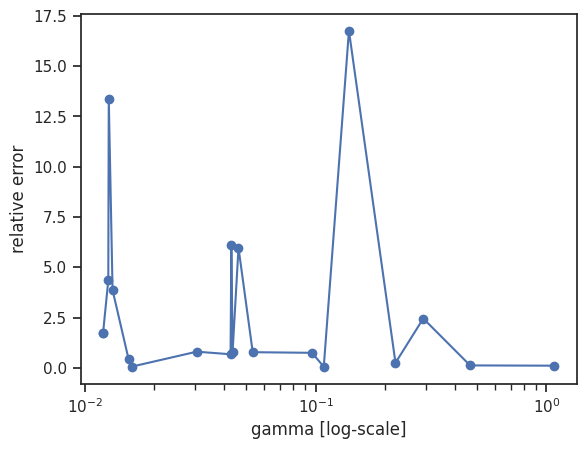

In [64]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - preds[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['normGamma'], chi, marker='o', label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

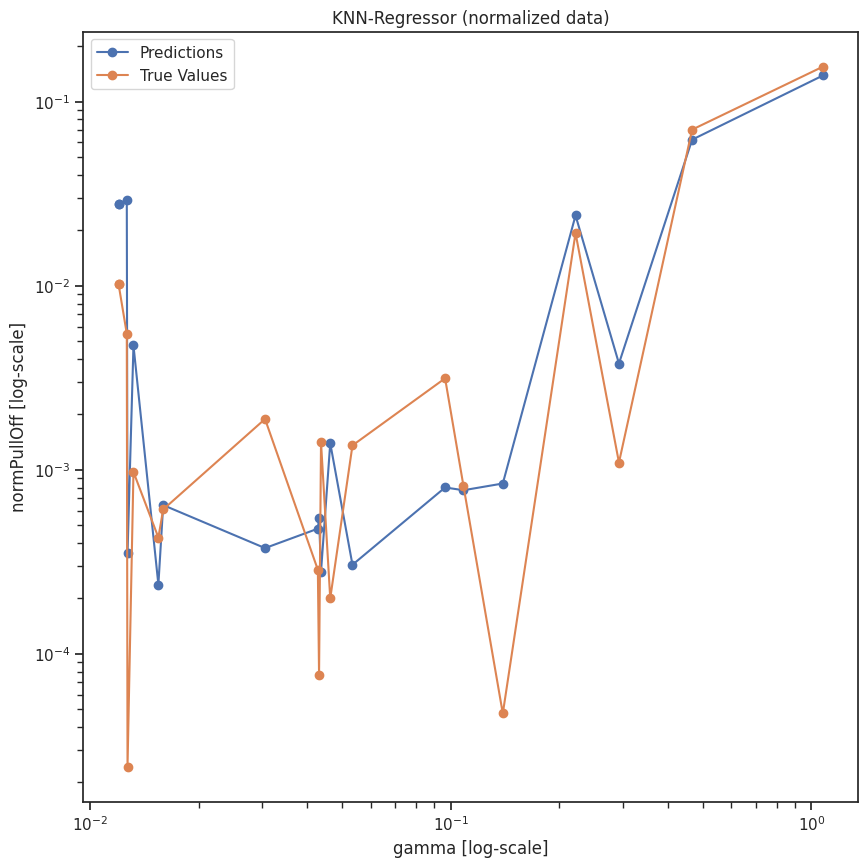

In [65]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["normGamma"], preds, marker='o', label='Predictions')
plt.plot(test_features["normGamma"], test_labels, marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("KNN-Regressor (normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [72]:
from sklearn.ensemble import VotingRegressor

rng = np.random.RandomState()

randForestReg = RandomForestRegressor(n_estimators=500, criterion="squared_error")
knn_reg = KNeighborsRegressor(n_neighbors=7, weights='distance', p=2)
grb = GradientBoostingRegressor(
    loss='huber',
    learning_rate=0.1,
    subsample=1.,
    n_estimators=300,
    max_depth=2,
    criterion='friedman_mse',
    alpha=0.8,
    warm_start=True,
)
ada_regr = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=12), n_estimators=300, learning_rate=.2, loss='square', random_state=rng
)

ereg = VotingRegressor(estimators=[('ada', ada_regr), ('grb', grb), ('knn', knn_reg), ('RF', randForestReg)])
ereg = ereg.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = ereg.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0000446701
Root Mean squared error: 0.0066835662
Mean absolute error: 0.0037337211
Coefficient of determination: 0.96518


[]

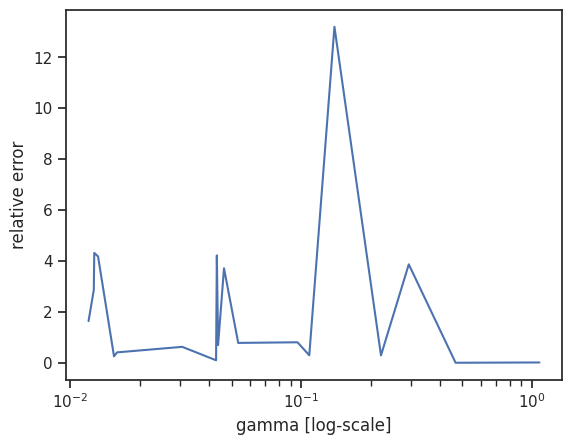

In [73]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - preds[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['normGamma'], chi, label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

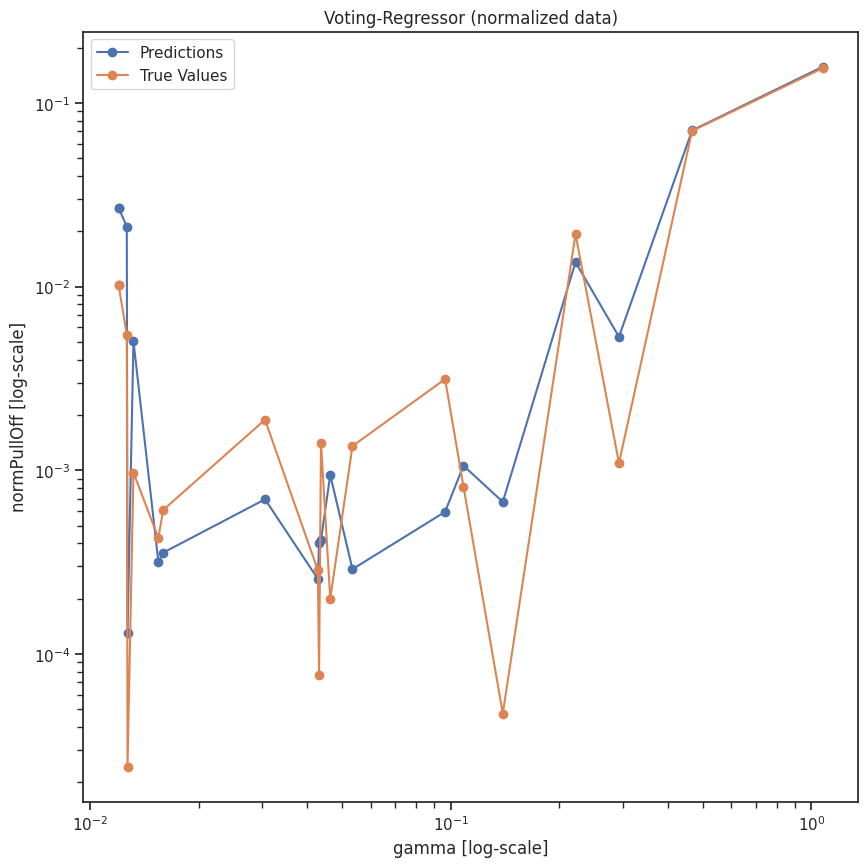

In [74]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["normGamma"], preds, marker='o', label='Predictions')
plt.plot(test_features["normGamma"], test_labels, marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("Voting-Regressor (normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [75]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
normRSMH,0.108308,0.055396
muT,0.771862,0.841460
normGamma,0.161256,0.232484
normPulloff,0.018767,0.051138


In [76]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[0.10830809 0.77186215 0.16125646]]


In [77]:
def loss(y_true, y_pred):
 # mse = keras.losses.mean_squared_error(y_true, y_pred)
  mae = keras.losses.mean_absolute_error(y_true, y_pred)
  return mae

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64),
      layers.LayerNormalization(),
      layers.Dropout(0.5),
      layers.ReLU(),
      layers.Dense(1)
  ])

  model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(1e-2))
  return model

In [78]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 3)                7         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 layer_normalization_1 (Laye  (None, 64)               128       
 rNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

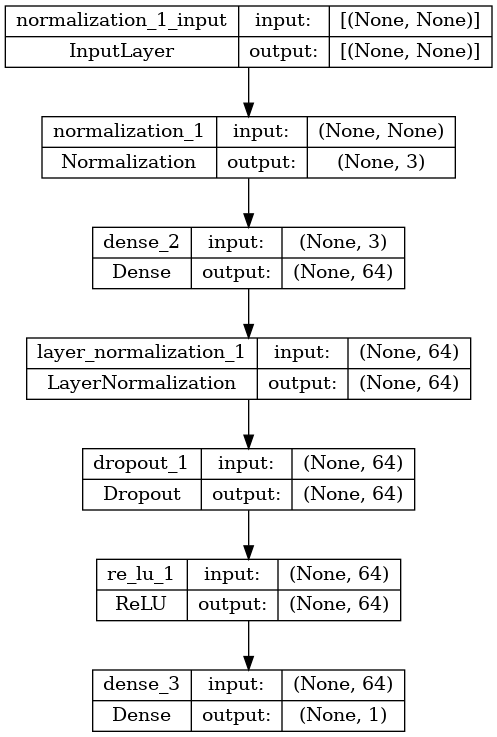

In [79]:
tf.keras.utils.plot_model(dnn_model, show_shapes=True)

In [80]:
batch_size = len(train_dataset) - (int) (len(train_dataset) * 0.2)

history = dnn_model.fit(
    train_features,
    pd.DataFrame(train_labels),
    batch_size=batch_size,
    validation_split=0.2,
    epochs=2000)

Epoch 1/2000
1/1 [==============================] - 1s 853ms/step - loss: 0.9559 - val_loss: 0.1978
Epoch 2/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.8495 - val_loss: 0.4101
Epoch 3/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.7982 - val_loss: 0.4040
Epoch 4/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.8079 - val_loss: 0.3013
Epoch 5/2000
1/1 [==============================] - 0s 44ms/step - loss: 0.7174 - val_loss: 0.1544
Epoch 6/2000
1/1 [==============================] - 0s 45ms/step - loss: 0.6269 - val_loss: 0.0827
Epoch 7/2000
1/1 [==============================] - 0s 44ms/step - loss: 0.5397 - val_loss: 0.1350
Epoch 8/2000
1/1 [==============================] - 0s 46ms/step - loss: 0.5016 - val_loss: 0.2232
Epoch 9/2000
1/1 [==============================] - 0s 42ms/step - loss: 0.4811 - val_loss: 0.2477
Epoch 10/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.4326 - val_loss: 0.2252
Epoch 11

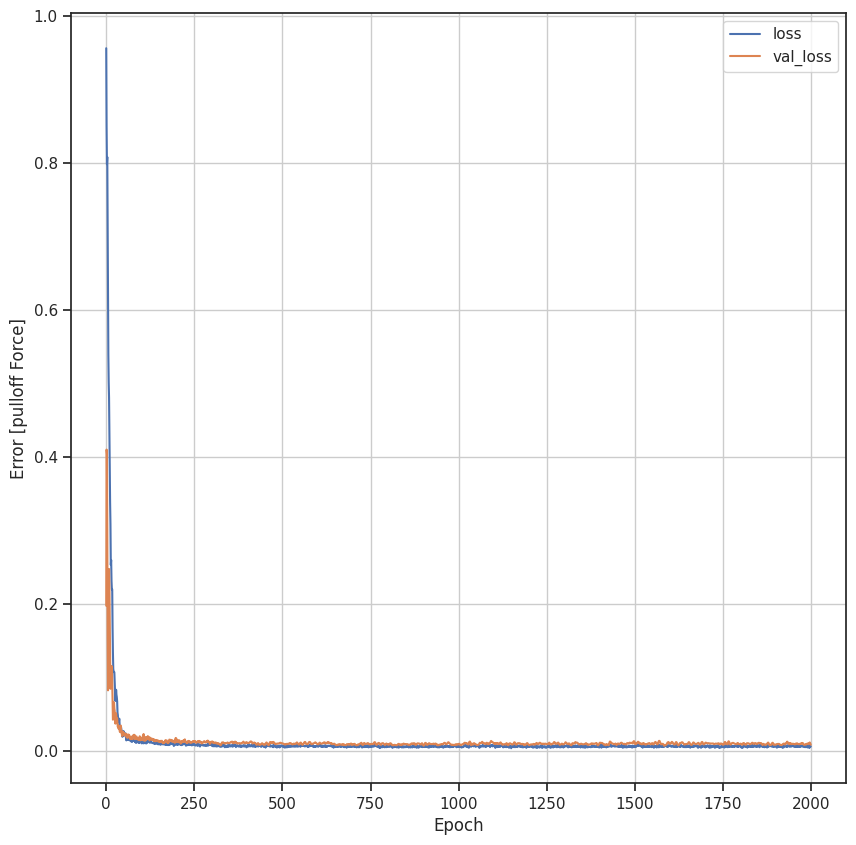

In [82]:
def plot_loss(history):
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [pulloff Force]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

1/1 [==============================] - 0s 99ms/step


[]

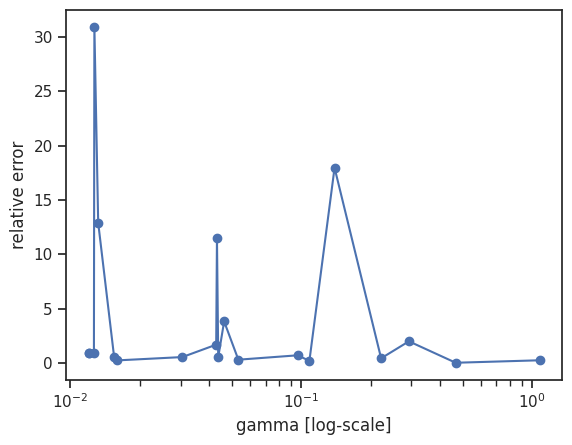

In [83]:
test_predictions = dnn_model.predict(test_features).flatten()
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i] - test_predictions[i]) / test_labels[i]
    chi.append(curr)

plt.plot(test_dataset['normGamma'], chi, marker='o', label='Chi Square')
plt.xscale('log')
plt.xlabel('gamma [log-scale]')
plt.ylabel('relative error')
plt.plot()

[]

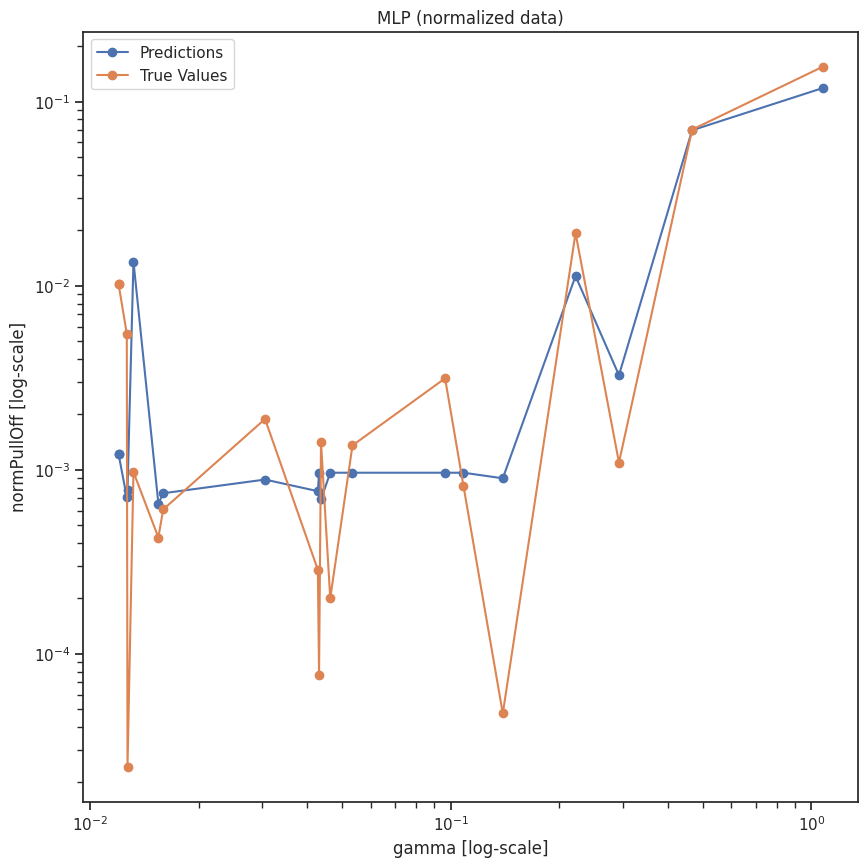

In [84]:
plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["normGamma"], test_predictions, marker='o', label='Predictions')
plt.plot(test_features["normGamma"], test_labels, marker='o', label='True Values')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("MLP (normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

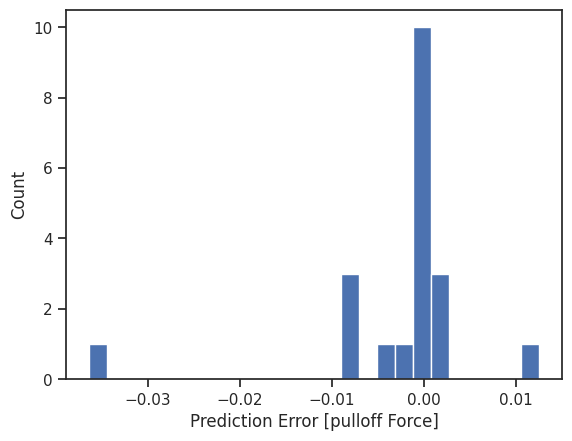

In [85]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [pulloff Force]')
_ = plt.ylabel('Count')

In [86]:
test_rmse = tf.math.sqrt(keras.losses.mean_squared_error(test_labels, test_predictions))
test_rmse.numpy()

0.009340273